# 在自己的数据集上训练2D人体关键点检测模型

参考文档：https://github.com/open-mmlab/mmpose/blob/master/demo/MMPose_Tutorial.ipynb

作者：同济子豪兄 2022-06-20

如果报错`CUDA out of memory.`则重启前面几个代码的`kernel`即可。

## 进入 MMPose 主目录

In [1]:
import os
os.chdir('mmpose')
os.listdir()

['.git',
 '.circleci',
 '.dev_scripts',
 '.github',
 '.gitignore',
 '.pre-commit-config.yaml',
 '.pylintrc',
 '.readthedocs.yml',
 'CITATION.cff',
 'LICENSE',
 'MANIFEST.in',
 'README.md',
 'README_CN.md',
 'configs',
 'demo',
 'docker',
 'docs',
 'mmpose',
 'model-index.yml',
 'pytest.ini',
 'requirements.txt',
 'requirements',
 'resources',
 'setup.cfg',
 'setup.py',
 'tests',
 'tools',
 'mmpose.egg-info',
 'checkpoints',
 'outputs',
 'data',
 'coco_tiny',
 'work_dirs']

## 导入工具包

In [2]:
import cv2

# 导入可视化工具包 matplotlib，并让绘制的图像嵌入在 notebook 中
import matplotlib.pyplot as plt
%matplotlib inline

# 定义可视化图像函数，输入图像路径，可视化图像
def show_img_from_path(img_path):
    '''opencv 读入图像，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img = cv2.imread(img_path)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()
    
# 定义可视化图像函数，输入图像 array，可视化图像
def show_img_from_array(img):
    '''输入 array，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

## 下载数据集

In [3]:
# 下载数据集压缩包至 data 目录
!wget https://download.openmmlab.com/mmpose/datasets/coco_tiny.tar -O data/coco_tiny.tar

--2022-06-21 17:55:29--  https://download.openmmlab.com/mmpose/datasets/coco_tiny.tar
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 16558080 (16M) [application/octet-stream]
Saving to: ‘data/coco_tiny.tar’

data/coco_tiny.tar  100%[===================>]  15.79M  --.-KB/s    in 0.1s    

2022-06-21 17:55:29 (107 MB/s) - ‘data/coco_tiny.tar’ saved [16558080/16558080]



In [4]:
# 进入 data 目录
os.chdir('data')

In [5]:
# 解压
!tar -xf coco_tiny.tar

In [6]:
# 回到 mmpose 目录
os.chdir('../')

## 查看标注文件

In [7]:
import json
import pprint

# 载入训练集标注文件
anns = json.load(open('data/coco_tiny/train.json'))

In [8]:
len(anns)

75

In [9]:
pprint.pprint(anns[0], compact=True)

{'bbox': [267.03, 104.32, 229.19, 320],
 'image_file': '000000537548.jpg',
 'image_size': [640, 480],
 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 325, 160, 2, 398,
               177, 2, 0, 0, 0, 437, 238, 2, 0, 0, 0, 477, 270, 2, 287, 255, 1,
               339, 267, 2, 0, 0, 0, 423, 314, 2, 0, 0, 0, 355, 367, 2]}


demo数据集包含100张来自 COCO train2017数据集的图像，训练集75张，测试集25张。

## 将数据集转为 mmpose 支持的类

把自己的关键点检测数据集，使用 mmpose 训练，有两种方法。

方法一：直接将数据集标注转为 mmpose 支持的数据集格式（例如 COCO）。在 mmpose 中使用对应的数据集类（例如 TopdownCOCODataset）训练。文档：https://mmpose.readthedocs.io/en/latest/tutorials/2_new_dataset.html#reorganize-dataset-to-existing-format

方法二：如果你自己的关键点检测数据集的标注格式与标准数据集（例如 COCO）不同。那么，需要手动写一个新的数据集类。在类中，读取标注文件内容并整理为一个 sample list，并实现数据集的 evaluate 接口。

以下展示方法一。

In [10]:
def convert_ann_to_coco_style(anns):
    anns_new = {
        'images': {},
        'annotations': [],
        'categories': [{'id': 1, 'name': 'person'}]
    }

    for i, item in enumerate(anns):
        if item['image_file'] not in anns_new['images']:
            anns_new['images'][item['image_file']] = {
                'file_name': item['image_file'],
                'height': item['image_size'][1],
                'width': item['image_size'][0],
                'id': len(anns_new['images']) + 1
            }
        anns_new['annotations'].append({
            'keypoints': item['keypoints'],
            'bbox': item['bbox'],
            'area': item['bbox'][2] * item['bbox'][3],
            'id': i + 1,
            'image_id': anns_new['images'][item['image_file']]['id'],
            'category_id': 1,
        })

    anns_new['images'] = list(anns_new['images'].values())
    return anns_new

In [ ]:
for phase in ('train', 'val'):
    with open(f'data/coco_tiny/{phase}.json', 'r') as f:
        anns = json.load(f)
    with open(f'data/coco_tiny/{phase}.json', 'w') as f:
        json.dump(convert_ann_to_coco_style(anns), f)

## 创建 config 配置文件

In [11]:
from mmcv import Config

# 模型 config 配置文件
cfg = Config.fromfile('./configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/hrnet_w32_coco_256x192.py')

# 基础配置
cfg.data_root = 'data/coco_tiny'
cfg.work_dir = 'work_dirs/hrnet_w32_coco_tiny_256x192'
cfg.gpu_ids = range(1)
cfg.seed = 0

# 日志间隔
cfg.log_config.interval = 1

# 评估指标
cfg.evaluation.interval = 10
cfg.evaluation.metric = 'mAP'
cfg.evaluation.save_best = 'AP'

# 学习率和训练策略
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=10,
    warmup_ratio=0.001,
    step=[17, 35])
cfg.total_epochs = 40

# batch size
cfg.data.samples_per_gpu = 16
cfg.data.val_dataloader = dict(samples_per_gpu=16)
cfg.data.test_dataloader = dict(samples_per_gpu=16)

# 数据集配置
cfg.data.train.ann_file = f'{cfg.data_root}/train.json'
cfg.data.train.img_prefix = f'{cfg.data_root}/images/'

cfg.data.val.ann_file = f'{cfg.data_root}/val.json'
cfg.data.val.img_prefix = f'{cfg.data_root}/images/'
cfg.data.val.data_cfg.use_gt_bbox = True

cfg.data.test.ann_file = f'{cfg.data_root}/val.json'
cfg.data.test.img_prefix = f'{cfg.data_root}/images/'
cfg.data.test.data_cfg.use_gt_bbox = True

In [12]:
print(cfg.pretty_text)

checkpoint_config = dict(interval=10)
log_config = dict(interval=1, hooks=[dict(type='TextLoggerHook')])
log_level = 'INFO'
load_from = None
resume_from = None
dist_params = dict(backend='nccl')
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
dataset_info = dict(
    dataset_name='coco',
    paper_info=dict(
        author=
        'Lin, Tsung-Yi and Maire, Michael and Belongie, Serge and Hays, James and Perona, Pietro and Ramanan, Deva and Doll{\'a}r, Piotr and Zitnick, C Lawrence',
        title='Microsoft coco: Common objects in context',
        container='European conference on computer vision',
        year='2014',
        homepage='http://cocodataset.org/'),
    keypoint_info=dict({
        0:
        dict(name='nose', id=0, color=[51, 153, 255], type='upper', swap=''),
        1:
        dict(
            name='left_eye',
            id=1,
            color=[51, 153, 255],
            type='upper',
            swap='right_eye'),
        2:
        dict

## 训练

In [13]:
from mmpose.datasets import build_dataset
from mmpose.models import build_posenet
from mmpose.apis import train_model
import mmcv

# build 数据集
datasets = [build_dataset(cfg.data.train)]

# build 模型
model = build_posenet(cfg.model)

# 创建 work_dir 目录
mmcv.mkdir_or_exist(cfg.work_dir)

# train model
train_model(model, datasets, cfg, distributed=False, validate=True, meta=dict())

load checkpoint from http path: https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w32-36af842e.pth


2022-06-21 17:56:15,237 - mmpose - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.0.0.0.conv1.weight, head.0.0.0.bn1.weight, head.0.0.0.bn1.bias, head.0.0.0.bn1.running_mean, head.0.0.0.bn1.running_var, head.0.0.0.bn1.num_batches_tracked, head.0.0.0.conv2.weight, head.0.0.0.bn2.weight, head.0.0.0.bn2.bias, head.0.0.0.bn2.running_mean, head.0.0.0.bn2.running_var, head.0.0.0.bn2.num_batches_tracked, head.0.0.0.conv3.weight, head.0.0.0.bn3.weight, head.0.0.0.bn3.bias, head.0.0.0.bn3.running_mean, head.0.0.0.bn3.running_var, head.0.0.0.bn3.num_batches_tracked, head.0.0.0.downsample.0.weight, head.0.0.0.downsample.1.weight, head.0.0.0.downsample.1.bias, head.0.0.0.downsample.1.running_mean, head.0.0.0.downsample.1.running_var, head.0.0.0.downsample.1.num_batches_tracked, head.0.1.0.conv1.weight, head.0.1.0.bn1.weight, head.0.1.0.bn1.bias, head.0.1.0.bn1.running_mean, head.0.1.0.bn1.running_var, head.0.1.0.bn1.num_batches_tracked, he

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 35.1 task/s, elapsed: 1s, ETA:     0s

2022-06-21 17:57:08,911 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_10.pth.
2022-06-21 17:57:08,912 - mmpose - INFO - Best PCK is 0.0988 at 10 epoch.
2022-06-21 17:57:08,914 - mmpose - INFO - Epoch(val) [10][2]	PCK: 0.0988
2022-06-21 17:57:11,790 - mmpose - INFO - Epoch [11][1/5]	lr: 5.045e-05, eta: 0:02:14, time: 2.867, data_time: 2.407, memory: 2919, heatmap_loss: 0.0022, acc_pose: 0.1860, loss: 0.0022
2022-06-21 17:57:12,180 - mmpose - INFO - Epoch [11][2/5]	lr: 5.145e-05, eta: 0:02:11, time: 0.390, data_time: 0.006, memory: 2919, heatmap_loss: 0.0023, acc_pose: 0.2071, loss: 0.0023
2022-06-21 17:57:12,550 - mmpose - INFO - Epoch [11][3/5]	lr: 5.245e-05, eta: 0:02:09, time: 0.370, data_time: 0.004, memory: 2919, heatmap_loss: 0.0018, acc_pose: 0.2113, loss: 0.0018
2022-06-21 17:57:12,904 - mmpose - INFO - Epoch [11][4/5]	lr: 5.345e-05, eta: 0:02:07, time: 0.355, data_time: 0.004, memory: 2919, heatmap_loss: 0.0015, acc_pose: 0.1480, loss: 0.0015
2022-06-21 17:57

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 37.6 task/s, elapsed: 1s, ETA:     0s

2022-06-21 17:57:54,659 - mmpose - INFO - The previous best checkpoint /home/featurize/work/MMPose教程/mmpose/work_dirs/hrnet_w32_coco_tiny_256x192/best_PCK_epoch_10.pth was removed
2022-06-21 17:57:55,947 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_20.pth.
2022-06-21 17:57:55,948 - mmpose - INFO - Best PCK is 0.1505 at 20 epoch.
2022-06-21 17:57:55,949 - mmpose - INFO - Epoch(val) [20][2]	PCK: 0.1505
2022-06-21 17:57:58,776 - mmpose - INFO - Epoch [21][1/5]	lr: 1.004e-04, eta: 0:01:26, time: 2.818, data_time: 2.366, memory: 2919, heatmap_loss: 0.0016, acc_pose: 0.3390, loss: 0.0016
2022-06-21 17:57:59,156 - mmpose - INFO - Epoch [21][2/5]	lr: 1.014e-04, eta: 0:01:25, time: 0.382, data_time: 0.007, memory: 2919, heatmap_loss: 0.0017, acc_pose: 0.2391, loss: 0.0017
2022-06-21 17:57:59,526 - mmpose - INFO - Epoch [21][3/5]	lr: 1.024e-04, eta: 0:01:24, time: 0.369, data_time: 0.005, memory: 2919, heatmap_loss: 0.0016, acc_pose: 0.3816, loss: 0.0016
2022-06-21 17:57:59,8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 35.6 task/s, elapsed: 1s, ETA:     0s

2022-06-21 17:58:42,835 - mmpose - INFO - The previous best checkpoint /home/featurize/work/MMPose教程/mmpose/work_dirs/hrnet_w32_coco_tiny_256x192/best_PCK_epoch_20.pth was removed
2022-06-21 17:58:44,239 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_30.pth.
2022-06-21 17:58:44,240 - mmpose - INFO - Best PCK is 0.1542 at 30 epoch.
2022-06-21 17:58:44,241 - mmpose - INFO - Epoch(val) [30][2]	PCK: 0.1542
2022-06-21 17:58:47,074 - mmpose - INFO - Epoch [31][1/5]	lr: 1.504e-04, eta: 0:00:42, time: 2.823, data_time: 2.375, memory: 2919, heatmap_loss: 0.0016, acc_pose: 0.5158, loss: 0.0016
2022-06-21 17:58:47,478 - mmpose - INFO - Epoch [31][2/5]	lr: 1.513e-04, eta: 0:00:41, time: 0.405, data_time: 0.008, memory: 2919, heatmap_loss: 0.0011, acc_pose: 0.4686, loss: 0.0011
2022-06-21 17:58:47,847 - mmpose - INFO - Epoch [31][3/5]	lr: 1.523e-04, eta: 0:00:40, time: 0.369, data_time: 0.004, memory: 2919, heatmap_loss: 0.0013, acc_pose: 0.4234, loss: 0.0013
2022-06-21 17:58:48,2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 35.1 task/s, elapsed: 1s, ETA:     0s

2022-06-21 17:59:30,363 - mmpose - INFO - The previous best checkpoint /home/featurize/work/MMPose教程/mmpose/work_dirs/hrnet_w32_coco_tiny_256x192/best_PCK_epoch_30.pth was removed
2022-06-21 17:59:31,752 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_40.pth.
2022-06-21 17:59:31,753 - mmpose - INFO - Best PCK is 0.1683 at 40 epoch.
2022-06-21 17:59:31,755 - mmpose - INFO - Epoch(val) [40][2]	PCK: 0.1683


## 使用训练得到的模型预测（和B1代码一致）

In [14]:
from mmpose.apis import inference_top_down_pose_model, init_pose_model, vis_pose_result, process_mmdet_results
from mmdet.apis import inference_detector, init_detector

### 指定模型`config`配置文件和`checkpoint`权重文件

In [16]:
# 目标检测模型
det_config = 'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 人体姿态估计模型
pose_config = 'configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/hrnet_w48_coco_256x192.py'
pose_checkpoint = 'work_dirs/hrnet_w32_coco_tiny_256x192/latest.pth'


### 初始化模型

In [17]:
# 目标检测模型
det_model = init_detector(det_config, det_checkpoint)

# 人体姿态估计模型
pose_model = init_pose_model(cfg, pose_checkpoint)


load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
load checkpoint from local path: work_dirs/hrnet_w32_coco_tiny_256x192/latest.pth


### 执行预测

In [35]:
# img_path = 'data/TongjiDancer.png'
img_path = 'tests/data/coco/000000196141.jpg'

mmdet_results = inference_detector(det_model, img_path)

# 提取类别 ID 为 1 的 行人 目标检测框
person_results = process_mmdet_results(mmdet_results, cat_id=1)

pose_results, returned_outputs = inference_top_down_pose_model(pose_model, img_path, person_results, bbox_thr=0.3, format='xyxy', dataset='TopDownCocoDataset')

vis_result = vis_pose_result(pose_model, img_path, pose_results, dataset='TopDownCocoDataset', show=False)

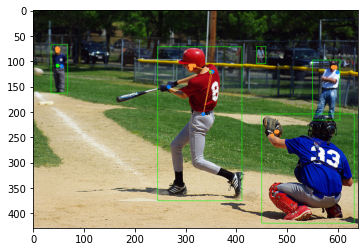

In [36]:
show_img_from_array(vis_result)

In [37]:
cv2.imwrite('outputs/B4.jpg', vis_result)

True